In [17]:
import glob 
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statannotations.Annotator import Annotator
from itertools import combinations

%matplotlib widget

Creating Wavenumber File

In [2]:
def create_wavenumber(input_dir, output_dir):
    spectrum_dir = glob.glob(f"{input_dir}/*/*/*.dpt")[0]
    wavenumber = pd.read_csv(spectrum_dir, usecols=[0])
    wavenumber.to_csv(f"{output_dir}/wavenumber.csv", index=False)

In [3]:
create_wavenumber(input_dir="data/raw", output_dir="data")

Averaging Quadrants

In [4]:
def average_quadrants(input_dir, output_dir):
    SCAN_NUMBERS = [16, 24, 32, 48, 64, 72]

    os.makedirs(output_dir, exist_ok=True)
    scan_dirs = sorted(glob.glob(f"{input_dir}/* scans"))

    for scan_num, scan_dir in zip(SCAN_NUMBERS, scan_dirs):
        ave_qs_df = pd.DataFrame()
        sample_dirs = sorted(
            glob.glob(f"{scan_dir}/Sample *"), key=lambda x: int(x.split(" ")[-2])
        )

        for sample_idx, sample_dir in enumerate(sample_dirs, start=1):
            compiled_quadrants = pd.DataFrame()
            quadrat_dirs = glob.glob(f"{sample_dir}/*.dpt")

            for quadrant_idx, quandrant_dir in enumerate(quadrat_dirs, start=1):
                spectrum = pd.read_csv(f"{quandrant_dir}", usecols=[1])
                compiled_quadrants[f"sample{sample_idx}_quadrant{quadrant_idx}"] = (
                    spectrum
                )

            ave_qs = compiled_quadrants.mean(axis=1).squeeze()
            ave_qs_df[f"sample_{sample_idx}"] = ave_qs

        ave_qs_df.to_csv(f"{output_dir}/{scan_num}.csv", index=False)

In [5]:
average_quadrants(input_dir="data/raw", output_dir="data/averaged_quadrants")

Visualization of Spectra

In [6]:
def visualize_spectra(input_dir, wavenumber_dir):
    SCAN_NUMBERS = [16, 24, 32, 48, 64, 72]
    scan_no_dirs = sorted(glob.glob(f"{input_dir}/*.csv"))
    wavenumber = pd.read_csv(wavenumber_dir)

    main_fig, main_axes = plt.subplots(2, 3, figsize=(10, 5))

    main_fig.suptitle(
        "ATR-FTIR Spectra of $A. japonica$ Protein Extract Over Different Scan Numbers"
    )

    main_fig.supxlabel("Wavenumber (cm$^{-1}$)")
    main_fig.supylabel("Absorbance")

    for main_axis, scan_no, scan_no_dir in zip(
        main_axes.flatten(), SCAN_NUMBERS, scan_no_dirs
    ):
        main_axis.set(title=f"{scan_no} Scans")

        scan_compiled = pd.read_csv(scan_no_dir)

        for sample in scan_compiled:
            main_axis.plot(
                wavenumber, scan_compiled[sample], color="black", linewidth=0.3
            )

    main_fig.tight_layout()
    main_fig.savefig("figures/Spectra of Each Scan Number.png", dpi=500)

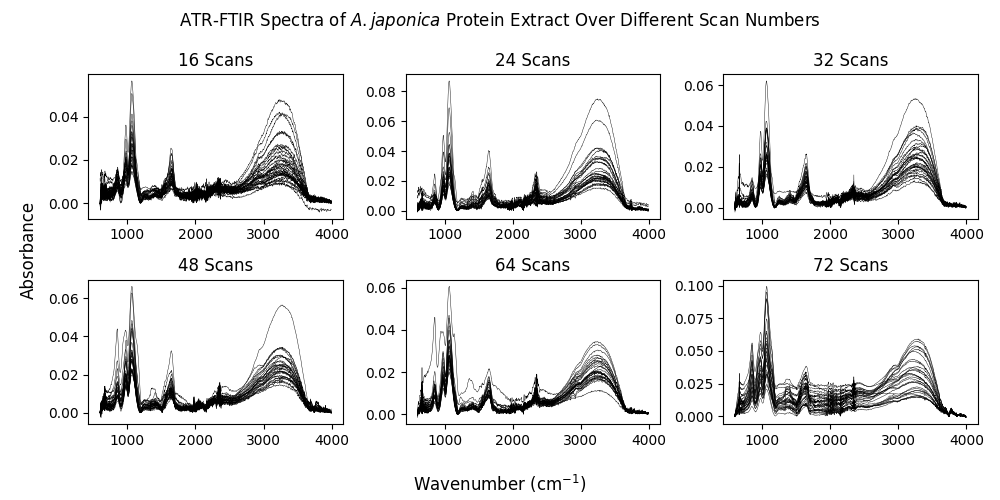

In [7]:
plt.close("all")
visualize_spectra(
    input_dir="data/averaged_quadrants", wavenumber_dir="data/wavenumber.csv"
)

Moment Distance Index (MDI) Computation

In [8]:
def mdi_compute(input_dir, wavenumber_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Loading Data
    csv_paths = glob.glob(f"{input_dir}/*.csv")
    wavenumber = pd.read_csv(f"{wavenumber_dir}").squeeze()

    scan_no_dict = {
        path.split("\\")[-1].replace(".csv", ""): pd.read_csv(path)
        for path in csv_paths
    }

    # Computing MDI
    lp = 3996.73391
    rp = 599.51009
    i = wavenumber

    result_df = pd.DataFrame()

    for key, df in scan_no_dict.items():

        mdi_results = []

        for sample in df.columns:
            p = df[sample]
            md_lp = sum(((p**2) + ((i - lp)) ** 2) ** 0.5)
            md_rp = sum(((p**2) + ((rp - i)) ** 2) ** 0.5)
            mdi = md_rp - md_lp
            mdi_results.append(mdi)

        result_df[f"{key}_mdi"] = pd.Series(mdi_results)

    result_df.to_csv(f"{output_dir}/master_mdi.csv", index=False)

In [9]:
mdi_compute(
    input_dir="data/averaged_quadrants",
    wavenumber_dir="data/wavenumber.csv",
    output_dir="data/mdi_results",
)

MDI Hypothesis Testing

In [10]:
def compare_mdi(mdi_results_dir):
    mdi_results = pd.read_csv(mdi_results_dir)
    mdi_results_melted = pd.melt(mdi_results, var_name="scan_no", value_name="smdi")
    normality = pg.normality(data=mdi_results, method="shapiro")
    homoscedasticity = pg.homoscedasticity(data=mdi_results, method="levene")
    kruskal = pg.kruskal(
        data=mdi_results_melted, dv="smdi", between="scan_no", detailed=True
    )

    print(f"{'NORMALITY TEST':-^40}\n", normality)
    print(f"\n{'HOMOSCEDASTICITY TEST':-^40}\n", homoscedasticity)
    print(f"\n{'KRUSKAL-WALLIS TEST':-^40}\n", kruskal)

In [11]:
compare_mdi("data/mdi_results/master_mdi.csv")

-------------NORMALITY TEST-------------
                W          pval  normal
16_mdi  0.195220  1.020056e-11   False
24_mdi  0.301650  7.284547e-11   False
32_mdi  0.947254  1.426615e-01    True
48_mdi  0.718543  2.937928e-06   False
64_mdi  0.475871  3.005984e-09   False
72_mdi  0.863561  1.208388e-03   False

---------HOMOSCEDASTICITY TEST----------
                W      pval  equal_var
levene  1.386836  0.231432       True

----------KRUSKAL-WALLIS TEST-----------
           Source  ddof1          H         p-unc
Kruskal  scan_no      5  48.776034  2.465898e-09


Standardized Moment Distance Index (SMDI) Computation

In [12]:
def smdi_compute(mdi_results_dir: str, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)

    # Loading Data
    master_mdi = pd.read_csv(mdi_results_dir)

    # Computing SMDI
    result_df = pd.DataFrame()

    scan_n_max = master_mdi.max()
    scan_n_min = master_mdi.min()

    global_max = scan_n_max.max()
    global_min = scan_n_min.min()

    mdi_range = global_max - global_min

    for col in master_mdi.columns:
        smdi = (master_mdi[col] - global_min) / (mdi_range)
        result_df[col] = pd.Series(smdi)

    result_df.to_csv(f"{output_dir}/master_smdi.csv", index=False)

In [13]:
smdi_compute(
    mdi_results_dir="data/mdi_results/master_mdi.csv", output_dir="data/mdi_results"
)

Visualization of SMDI

In [ ]:
def visualize_smdi(smdi_results_dir, mdi_results_dir):
    SCAN_NUMBERS = [16, 24, 32, 48, 64, 72]
    smdi_df = pd.read_csv(smdi_results_dir)
    smdi_long = smdi_df.melt(var_name="scan", value_name="smdi")
    mdi_df = pd.read_csv(mdi_results_dir)
    mdi_mean, mdi_std = mdi_df.mean(), mdi_df.std()

    main_fig, main_axis = plt.subplots(1, 1, figsize=(10, 8))
    main_fig.suptitle("Standardized Moment Distance Index (SMDI) of Each Scan Number")
    main_fig.supxlabel("Scan Numbers")
    main_fig.supylabel("SMDI")

    sns.boxplot(data=smdi_long, ax=main_axis, x="scan", y="smdi")

    main_axis.set(
        xticks=[i for i in range(len(SCAN_NUMBERS))],
        xticklabels=[f"{n} Scans" for n in SCAN_NUMBERS],
        xlabel=None,
        ylabel=None,
    )

    for (
        scan_no,
        mean,
        std,
    ) in zip(main_axis.get_xticks(), mdi_mean, mdi_std):

        main_axis.text(
            x=scan_no,
            y=0.5,
            s=f"{mean:.2f}\n±\n{std:.7f}",
            ha="center",
            va="center",
        )

    scan_labels = smdi_long["scan"].unique()
    pairs = list(combinations(scan_labels, 2))

    annotator = Annotator(main_axis, pairs, data=smdi_long, x="scan", y="smdi")
    annotator.configure(
        test="Mann-Whitney", text_format="star", loc="inside", hide_non_significant=True
    )
    annotator.apply_and_annotate()

    main_fig.tight_layout()
    main_fig.savefig("figures/SMDI of Each Scan Number.png", dpi=500)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

16_mdi vs. 24_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:4.982e-04 U_stat=6.860e+02
32_mdi vs. 48_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:6.549e-04 U_stat=2.190e+02
64_mdi vs. 72_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:6.913e-04 U_stat=2.200e+02
16_mdi vs. 32_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:2.959e-05 U_stat=7.330e+02
24_mdi vs. 48_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:3.671e-03 U_stat=2.530e+02
32_mdi vs. 64_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:3.182e-04 U_stat=2.060e+02
48_mdi vs. 72_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:9.031e-04 U_stat=2.250e+02
24_mdi vs. 64_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:2.157e-03 U_stat=2.420e+02
32_mdi vs. 72_mdi: Mann-Whitney-Wilcoxon test two-sided, P_val:1.194e-06 U_stat=1.210e+0

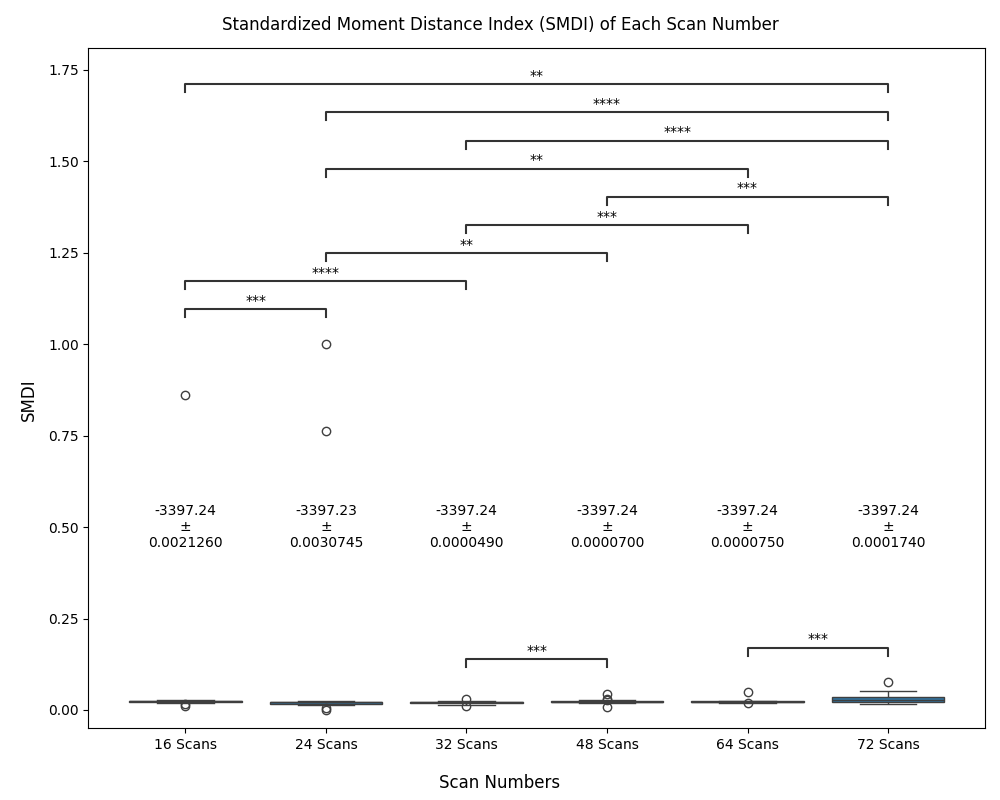

In [73]:
plt.close("all")
visualize_smdi(
    smdi_results_dir="data/mdi_results/master_smdi.csv",
    mdi_results_dir="data/mdi_results/master_mdi.csv",
)